# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [ ]:
!mkdir cifar10
!curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz -C cifar10

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

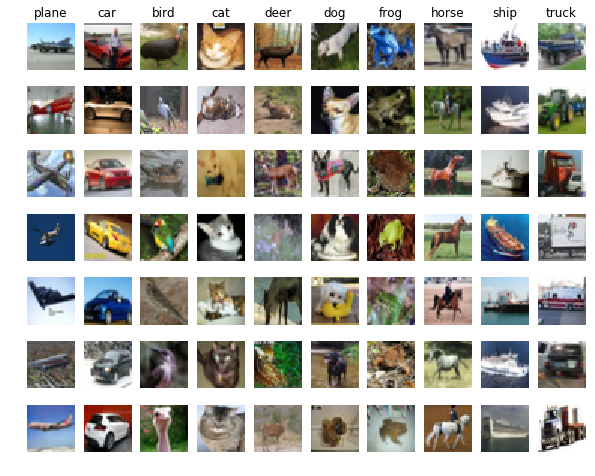

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
X_val = X_test[:8000]
y_val = y_test[:8000]
X_test = X_test[8000:]
y_test = y_test[8000:]

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

<Ответ>

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

<Ответ>


**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

<Ответ>

**Вопрос 4**: Как сделать стайл трансфер для музыки? oO

<Ответ>

In [5]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *
from lasagne import init, nonlinearities as nl, layers as ll
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import Pool2DLayer as MaxPool2DLayer
from lasagne.layers import BatchNormLayer 

Using cuDNN version 5110 on context None
Mapped name None to device cuda0: GRID K520 (0000:00:03.0)


### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Have fun :)

In [6]:
input_x, target_y, Winit = T.tensor4("input"), T.vector("target", dtype='int32'), init.Normal()

k = 1.5

def conv_bn_rectify(net, num_filters):
    net = ConvLayer(net, int(num_filters), 3, W=init.Normal(), pad=1, nonlinearity=None)
    net = BatchNormLayer(net, epsilon=1e-3)
    net = ll.NonlinearityLayer(net)
    return net

net = ll.InputLayer((None, 3, 32, 32), input_x)
net = conv_bn_rectify(net, 64 * k)
net = ll.DropoutLayer(net, 0.3)
net = conv_bn_rectify(net, 64 * k)
net = MaxPool2DLayer(net, 2, 2)

net = conv_bn_rectify(net, 128 * k)
net = ll.DropoutLayer(net, 0.4)
net = conv_bn_rectify(net, 128 * k)
net = MaxPool2DLayer(net, 2, 2)

net = conv_bn_rectify(net, 256 * k)
net = ll.DropoutLayer(net, 0.4)
net = conv_bn_rectify(net, 256 * k)
net = ll.DropoutLayer(net, 0.4)
net = conv_bn_rectify(net, 256 * k)
net = MaxPool2DLayer(net, 2, 2)

net = conv_bn_rectify(net, 512 * k)
net = ll.DropoutLayer(net, 0.4)
net = conv_bn_rectify(net, 512 * k)
net = ll.DropoutLayer(net, 0.4)
net = conv_bn_rectify(net, 512 * k)
net = MaxPool2DLayer(net, 2, 2)

net = conv_bn_rectify(net, 512 * k)
net = ll.DropoutLayer(net, 0.4)
net = conv_bn_rectify(net, 512 * k)
net = ll.DropoutLayer(net, 0.4)
net = conv_bn_rectify(net, 512 * k)
net = MaxPool2DLayer(net, 2, 2)

net = ll.DenseLayer(net, int(512 * k), W=init.Normal(), nonlinearity=nl.rectify)
net = BatchNormLayer(net, epsilon=1e-3)
net = ll.NonlinearityLayer(net)
net = ll.DropoutLayer(net, 0.5)
net = ll.DenseLayer(net, 10, W=init.Normal(), nonlinearity=nl.softmax)

In [7]:
y_predicted = lasagne.layers.get_output(net)
all_weights = lasagne.layers.get_all_params(net, trainable=True)
print all_weights

[W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b]


In [8]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()

In [9]:
from lasagne.updates import nesterov_momentum
learning_rate = 0.001
momentum = 0.9
updates = nesterov_momentum(loss, all_weights, learning_rate=learning_rate, momentum=momentum)
train_fun = theano.function([input_x,target_y],[loss, accuracy], updates=updates, allow_input_downcast=True)
accuracy_fun = theano.function([input_x,target_y], accuracy, allow_input_downcast=True)

### Вот и всё, пошли её учить

In [10]:
from scipy import swapaxes

def proper_format(image):
    image = swapaxes(image, 1, 2)
    return swapaxes(image, 0, 1)
def display_format(image):
    image = swapaxes(image, 0, 1)
    return swapaxes(image, 1, 2)

def arr_proper_format(data):
    return np.array(map(proper_format, data))

def arr_display_format(data):
    return np.array(map(display_format, data))

def proper_from_keras(data):
    return np.array(map(lambda x: np.uint8(proper_format(x)), data))

In [14]:
def save_net(name):
    np.savez('pretrained/' + name, *lasagne.layers.get_all_param_values(net))

def load_net(name):
    with np.load('pretrained/' + name + '.npz') as f:
        param_values = [f['arr_%d' % i] for i in range(len(f.files))]
        lasagne.layers.set_all_param_values(net, param_values)

In [17]:
from keras.preprocessing.image import ImageDataGenerator
import time

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
        
def train_net(num_epochs, learning_rate, momentum, period=10, lr_decay=0.2, m_decay=1.):
        
    datagen = ImageDataGenerator(
        zoom_range=0.05,
        rotation_range=1,
#         width_shift_range=0.05,
#         height_shift_range=0.05,
        horizontal_flip=True)
    X_train_datagen = arr_display_format(X_train)
    datagen.fit(X_train_datagen)
    
    batch_size = 64
    updates = lasagne.updates.nesterov_momentum(loss, all_weights, learning_rate=learning_rate, momentum=momentum)
    train_fun = theano.function([input_x, target_y], [loss, accuracy], updates=updates, allow_input_downcast=True)
    
    save_val_acc = 0
    
    for epoch in range(num_epochs):
        
        if epoch % period == 0 and epoch > 0:
            learning_rate *= lr_decay
            momentum *= m_decay
            updates = nesterov_momentum(loss, all_weights, learning_rate=learning_rate, momentum=momentum)
            train_fun = theano.function([input_x,target_y],[loss, accuracy], updates=updates, allow_input_downcast=True)
            save_net('k-'+str(k)+'-acc-'+str(save_val_acc))
        
        train_err, train_acc, train_batches = 0, 0, 0
        start_time = time.time()
        for batch in datagen.flow(X_train_datagen, y_train, batch_size=batch_size):            
            inputs, targets = batch
            inputs = proper_from_keras(inputs)
            train_err_batch, train_acc_batch= train_fun(inputs, targets)
            train_err += train_err_batch
            train_acc += train_acc_batch
            train_batches += 1
            if train_batches > len(X_train)/batch_size:
                break
                
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            val_acc += accuracy_fun(inputs, targets)
            val_batches += 1

        save_val_acc = val_acc / val_batches * 100
            # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
        print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
        print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

# Процесс обучения

In [14]:
train_net(100, 0.001, 0.9, period=105, lr_decay=0.1)

Epoch 1 of 100 took 807.093s
  training loss (in-iteration):		1.983165
  train accuracy:		22.94 %
  validation accuracy:		33.23 %
Epoch 2 of 100 took 807.079s
  training loss (in-iteration):		1.572591
  train accuracy:		40.26 %
  validation accuracy:		47.71 %
Epoch 3 of 100 took 806.988s
  training loss (in-iteration):		1.313841
  train accuracy:		51.61 %
  validation accuracy:		56.80 %
Epoch 4 of 100 took 806.979s
  training loss (in-iteration):		1.128774
  train accuracy:		59.53 %
  validation accuracy:		63.32 %
Epoch 5 of 100 took 807.023s
  training loss (in-iteration):		1.015906
  train accuracy:		63.54 %
  validation accuracy:		65.99 %
Epoch 6 of 100 took 806.971s
  training loss (in-iteration):		0.921236
  train accuracy:		67.36 %
  validation accuracy:		69.12 %
Epoch 7 of 100 took 806.877s
  training loss (in-iteration):		0.863787
  train accuracy:		69.71 %
  validation accuracy:		71.45 %
Epoch 8 of 100 took 806.902s
  training loss (in-iteration):		0.810936
  train accuracy:		

MemoryError: 

In [17]:
train_net(30, 0.001, 0.9, period=105, lr_decay=0.1)

Epoch 1 of 30 took 803.980s
  training loss (in-iteration):		0.424391
  train accuracy:		85.72 %
  validation accuracy:		85.26 %
Epoch 2 of 30 took 803.943s
  training loss (in-iteration):		0.411110
  train accuracy:		85.91 %
  validation accuracy:		84.65 %
Epoch 3 of 30 took 803.952s
  training loss (in-iteration):		0.405803
  train accuracy:		86.19 %
  validation accuracy:		85.02 %
Epoch 4 of 30 took 803.933s
  training loss (in-iteration):		0.398151
  train accuracy:		86.45 %
  validation accuracy:		85.17 %
Epoch 5 of 30 took 803.914s
  training loss (in-iteration):		0.392491
  train accuracy:		86.62 %
  validation accuracy:		85.76 %
Epoch 6 of 30 took 803.878s
  training loss (in-iteration):		0.386950
  train accuracy:		86.80 %
  validation accuracy:		85.50 %
Epoch 7 of 30 took 803.943s
  training loss (in-iteration):		0.373629
  train accuracy:		87.29 %
  validation accuracy:		85.96 %
Epoch 8 of 30 took 804.020s
  training loss (in-iteration):		0.365082
  train accuracy:		87.58 %


MemoryError: 

In [16]:
save_net('k-1.5|84.4')

In [19]:
save_net('k-1.5|87.95')

In [15]:
load_net('k-1.5|87.95')

In [16]:
train_net(30, 0.0001, 0.9, period=105, lr_decay=0.1)

Epoch 1 of 30 took 806.991s
  training loss (in-iteration):		0.270843
  train accuracy:		90.76 %
  validation accuracy:		87.81 %
Epoch 2 of 30 took 806.928s
  training loss (in-iteration):		0.257447
  train accuracy:		91.13 %
  validation accuracy:		87.91 %
Epoch 3 of 30 took 807.021s
  training loss (in-iteration):		0.253875
  train accuracy:		91.32 %
  validation accuracy:		88.11 %
Epoch 4 of 30 took 806.989s
  training loss (in-iteration):		0.251457
  train accuracy:		91.48 %
  validation accuracy:		88.36 %
Epoch 5 of 30 took 806.838s
  training loss (in-iteration):		0.246774
  train accuracy:		91.57 %
  validation accuracy:		88.14 %
Epoch 6 of 30 took 806.863s
  training loss (in-iteration):		0.243067
  train accuracy:		91.71 %
  validation accuracy:		88.16 %
Epoch 7 of 30 took 807.023s
  training loss (in-iteration):		0.244715
  train accuracy:		91.62 %
  validation accuracy:		88.62 %
Epoch 8 of 30 took 807.108s
  training loss (in-iteration):		0.236625
  train accuracy:		92.03 %


KeyboardInterrupt: 

In [18]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

Final results:
  test accuracy:		88.70 %
Нужно больше магии!


## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 

In [ ]:
print 5